# Advanced tutorial for query to reference mapping using expiMap with de novo learned gene programs

In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import numpy as np
import gdown

Global seed set to 0


In [3]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download reference and do preprocessing

In [4]:
url = 'https://drive.google.com/uc?id=1Rnm-XKEqPLdOq3lpa3ka2aV4bOXVCLP0'
output = 'pbmc_tutorial.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Rnm-XKEqPLdOq3lpa3ka2aV4bOXVCLP0
To: C:\Users\sergei.rybakov\projects\notebooks\pbmc_tutorial.h5ad
100%|███████████████████████████████████████████████████████████████████████████████| 231M/231M [00:42<00:00, 5.39MB/s]


'pbmc_tutorial.h5ad'

In [4]:
adata = sc.read('pbmc_tutorial.h5ad')

`.X` should contain raw counts.

In [5]:
adata.X = adata.layers["counts"].copy()

Read the Reactome annotations, make a binary matrix where rows represent gene symbols and columns represent the terms, and add the annotations matrix to the reference dataset. The binary matrix of annotations is stored in `adata.varm['I']`. Note that only terms with minimum of 12 genes in the reference dataset are retained.

In [ ]:
url = 'https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c'
output = 'reactome.gmt'
gdown.download(url, output, quiet=False)

In [6]:
sca.utils.add_annotations(adata, 'reactome.gmt', min_genes=12, clean=True)

Remove all genes which are not present in the Reactome annotations.

In [7]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

For a better model performance it is necessary to select HVGs. We are doing this by applying the `scanpy.pp` function `highly_variable_genes()`. The `n_top_genes` is set to 2000 here. However, for more complicated datasets you might have to increase number of genes to capture more diversity in the data.

In [8]:
sc.pp.normalize_total(adata)

In [9]:
sc.pp.log1p(adata)

In [10]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

Filter out any annotations (terms) with less than 12 genes.

In [11]:
select_terms = adata.varm['I'].sum(0)>12

In [12]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [13]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

Filter out genes not present in any retained terms after selection of HVGs.

In [14]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

Put the count data back to `adata.X`.

In [15]:
adata.X = adata.layers["counts"].copy()

### Example with constrained and unconstrained extension nodes

Later, we will use a query dataset that contains IFN-beta stimulated and unstimulated PBMC cells. 

Here, we remove some Interferon and B cell specific signals from the reference by dropping some related terms from the annotation matrix. The signals corresponding to these terms will be recovered later with the extension nodes added in the query at the surgery step.

Select the interferon annotations from the loaded Reactome pathway database for removal.

In [16]:
rm_terms = ['INTERFERON_SIGNALING', 'INTERFERON_ALPHA_BETA_SIGNALIN',
            'CYTOKINE_SIGNALING_IN_IMMUNE_S', 'ANTIVIRAL_MECHANISM_BY_IFN_STI']

Select the annotations related to B cells for removal.

In [17]:
rm_terms += ['SIGNALING_BY_THE_B_CELL_RECEPT', 'MHC_CLASS_II_ANTIGEN_PRESENTAT']

In [18]:
ix_f = []
for t in rm_terms:
    ix_f.append(adata.uns['terms'].index(t))

Store the 'SIGNALING_BY_THE_B_CELL_RECEPT' annotation separately.

In [19]:
query_mask = adata.varm['I'][:, ix_f[4]][:, None].copy()

Remove the selected annotations.

In [20]:
adata.varm['I'] = np.delete(adata.varm['I'], ix_f, axis=1)

In [21]:
adata.uns['terms'] = [term for term in adata.uns['terms'] if term not in rm_terms]

Remove B cells from the reference.

In [22]:
rm_b = ["B", "CD10+ B cells"]

In [23]:
adata = adata[~adata.obs['cell_type'].isin(rm_b)].copy()

### Train the reference.

In [24]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[300, 300, 300],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 300 4
	Hidden Layer 1 in/out: 300 300
	Hidden Layer 2 in/out: 300 300
	Mean/Var Layer in/out: 300 276
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  276 0 0 4 1972
	with hard mask.
Last Decoder layer: softmax


In [25]:
ALPHA = 0.7

In [26]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    seed=2020
)

Init the group lasso proximal operator for the main terms.
 |██████████████------| 72.2%  - val_loss: 935.2109799592 - val_recon_loss: 909.6967879586 - val_kl_loss: 51.0283828404208
ADJUSTED LR
 |███████████████-----| 76.8%  - val_loss: 934.3165150518 - val_recon_loss: 908.9699786642 - val_kl_loss: 50.6930810680
ADJUSTED LR
 |████████████████----| 80.2%  - val_loss: 934.5560806938 - val_recon_loss: 909.1601987092 - val_kl_loss: 50.7917618130
ADJUSTED LR
 |████████████████----| 83.5%  - val_loss: 934.7631597104 - val_recon_loss: 909.4011548913 - val_kl_loss: 50.7240132871
ADJUSTED LR
 |█████████████████---| 86.8%  - val_loss: 934.5707238239 - val_recon_loss: 909.2114868164 - val_kl_loss: 50.7184793224
ADJUSTED LR
 |█████████████████---| 89.5%  - val_loss: 934.3915139903 - val_recon_loss: 909.0323433254 - val_kl_loss: 50.7183265686
Stopping early: no improvement of more than 0 nats in 50 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters

### Referece mapping while learning new varation from query data with extension nodes

The Kang dataset contains control and IFN-beta stimulated cells. We use this as the query dataset.

In [ ]:
url = 'https://drive.google.com/uc?id=1t3oMuUfueUz_caLm5jmaEYjBxVNSsfxG'
output = 'kang_tutorial.h5ad'
gdown.download(url, output, quiet=False)

In [27]:
kang = sc.read('kang_tutorial.h5ad')[:, adata.var_names].copy()

In [28]:
kang.obs['study'] = 'Kang'

In [29]:
kang.uns['terms'] = adata.uns['terms']

Add 3 unconstrained (to capture de novo programs) and one constrained nodes, where the constrain represents the 'SIGNALING_BY_THE_B_CELL_RECEPT' term. Note that this term was dropped when the reference model was learned. Also use HSIC regularization for the unconstrained nodes to encourge independence of learned de novo gene programs.

In [30]:
q_intr_cvae = sca.models.EXPIMAP.load_query_data(kang, intr_cvae,
                                                 unfreeze_ext=True,
                                                 new_n_ext=3,
                                                 new_n_ext_m=1,
                                                 new_ext_mask=query_mask.T,
                                                 new_soft_ext_mask=True,
                                                 use_hsic=True,
                                                 hsic_one_vs_all=True
                                                )


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 300 5
	Hidden Layer 1 in/out: 300 300
	Hidden Layer 2 in/out: 300 300
	Mean/Var Layer in/out: 300 276
	Expanded Mean/Var Layer in/out: 300 4
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  276 1 3 5 1972
	with hard mask.
Last Decoder layer: softmax


Train with hypeparameters:

`gamma_ext` - L1 regularization coefficient for the new unconstrained nodes. Specifies the strength of sparcity enforcement for these nodes.

`gamma_epoch_anneal` - number of epochs for `gamma_ext` annealing.

`alpha_l1` - L1 regularization coefficient for the soft mask of the new constrained node.

`beta` - HSIC regularization coefficient for the unconstrained nodes, enforces their independence from the old reference nodes and from each other if `hsic_one_vs_all=True`.

In [31]:
q_intr_cvae.train(
    n_epochs=250, 
    alpha_epoch_anneal=120,
    alpha_kl=0.22,
    weight_decay=0., 
    alpha_l1=0.96,
    gamma_ext=0.7,
    gamma_epoch_anneal=50,
    beta=3.,
    seed=2020,
    use_early_stopping=False
)

Init the L1 proximal operator for the unannotated extension.
Init the soft mask proximal operator for the annotated extension.
 |████████████████████| 100.0%  - val_hsic_loss: 0.2133808624 - val_loss: 517.5771179199 - val_recon_loss: 501.4962740811 - val_kl_loss: 70.1850114302


### Analysis of the extension nodes for reference + query dataset

In [32]:
kang_pbmc = sc.AnnData.concatenate(adata, kang, batch_key='batch_join', uns_merge='same')

In [33]:
kang_pbmc.obs['condition_joint'] = kang_pbmc.obs.condition.astype(str)
kang_pbmc.obs['condition_joint'][kang_pbmc.obs['condition_joint'].astype(str)=='nan']='control'

This adds extension nodes' names to `kang_pbmc.uns['terms']`.

In [34]:
q_intr_cvae.update_terms(adata=kang_pbmc)

In [35]:
q_intr_cvae.latent_directions(adata=kang_pbmc)

Do gene set enrichment test for **condition** in reference + query using Bayes Factors.

In [36]:
q_intr_cvae.latent_enrich(groups='condition_joint', comparison='control', use_directions=True, adata=kang_pbmc)

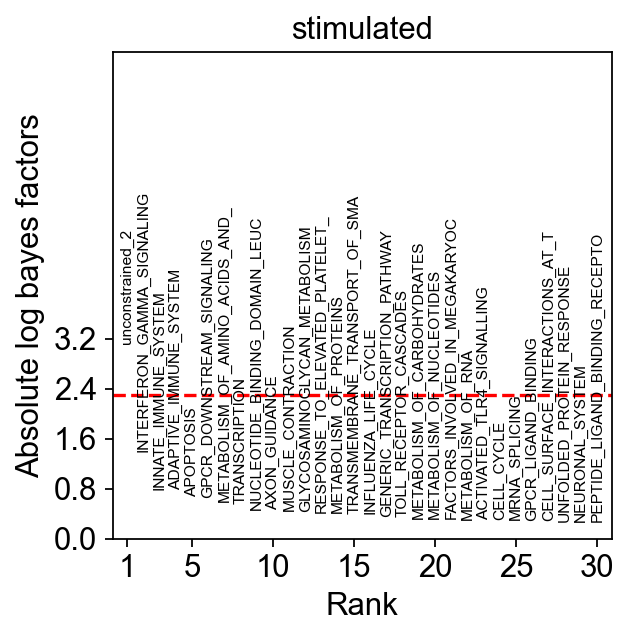

In [37]:
fig = sca.plotting.plot_abs_bfs(kang_pbmc, yt_step=0.8, scale_y=2.5, fontsize=7)

Do gene set enrichment test for **cell types** in reference + query control using Bayes Factors.

In [38]:
kang_pbmc_control = kang_pbmc[kang_pbmc.obs['condition_joint']=='control'].copy()

q_intr_cvae.latent_enrich(groups='cell_type', use_directions=True, adata=kang_pbmc_control, n_sample=10000)

In [ ]:
fig = sca.plotting.plot_abs_bfs(kang_pbmc_control, n_cols=3, scale_y=2.6, yt_step=0.6)

In [40]:
fig.set_size_inches(16, 34)

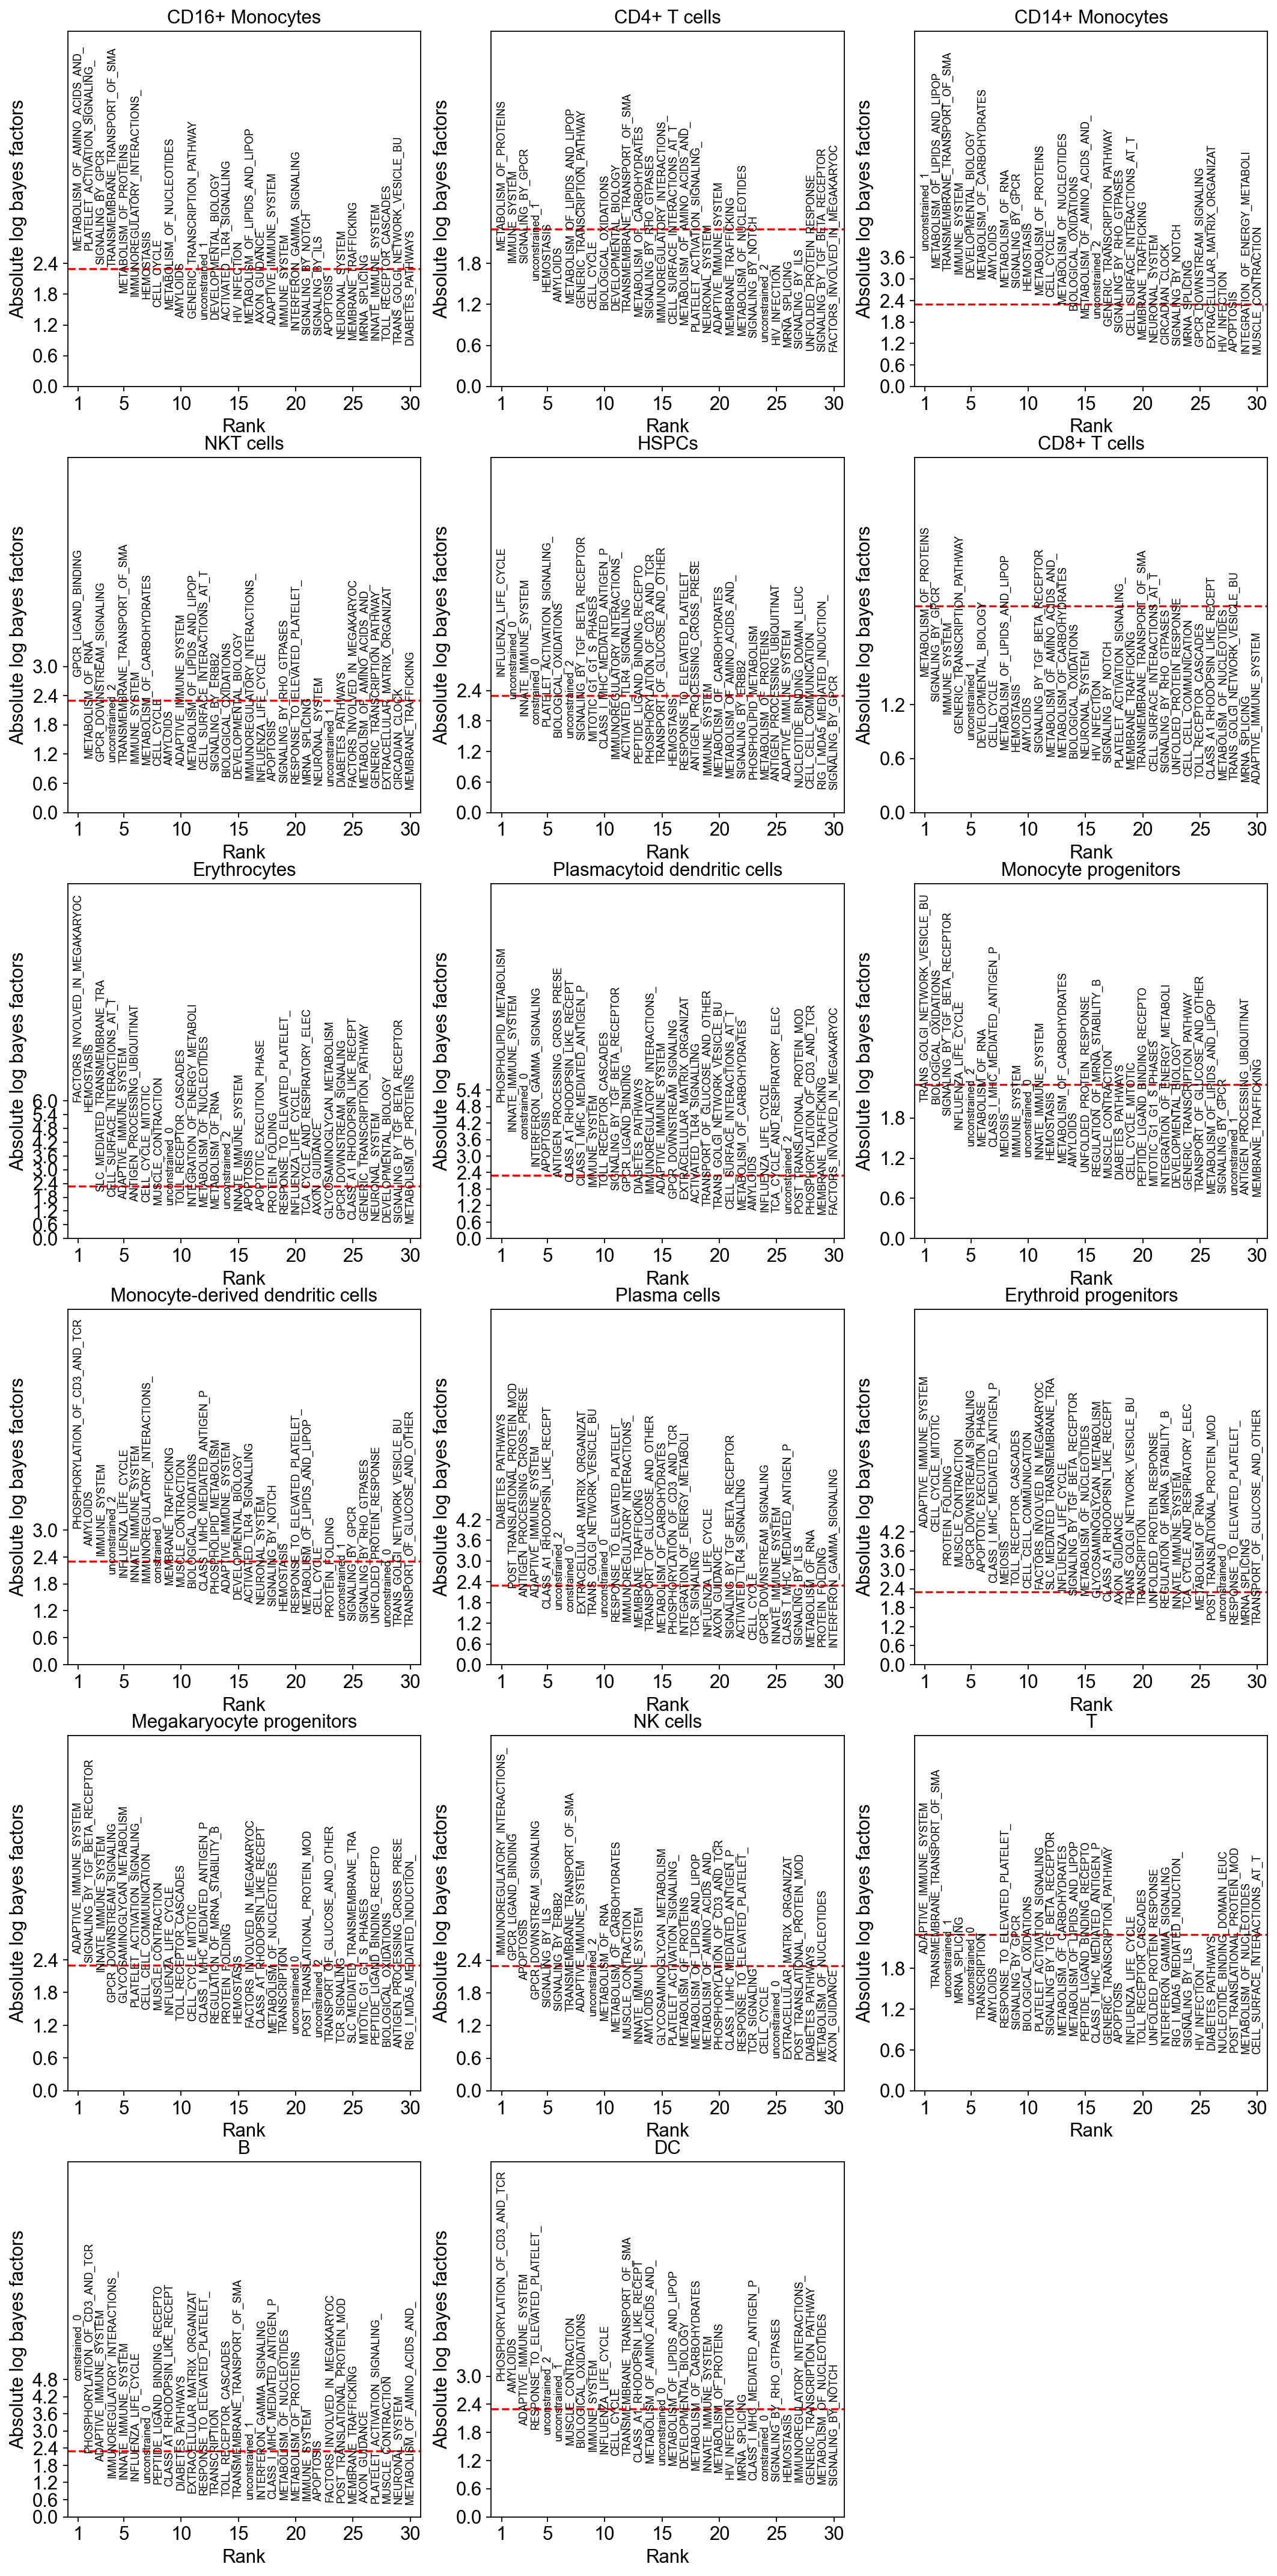

In [41]:
fig

Plot the latent variables for query + reference corresponding to the constrained and unconstrained extension nodes.

In [42]:
terms = kang_pbmc.uns['terms']
select_terms = ['constrained_0', 'unconstrained_0', 'unconstrained_1', 'unconstrained_2']
idx = [terms.index(term) for term in select_terms]

In [43]:
latents = (q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'], mean=False) * kang_pbmc.uns['directions'])[:, idx]

In [44]:
kang_pbmc.obs['constrained_0'] = latents[:, 0]

kang_pbmc.obs['unconstrained_0'] = latents[:, 1]
kang_pbmc.obs['unconstrained_1'] = latents[:, 2]
kang_pbmc.obs['unconstrained_2'] = latents[:, 3]

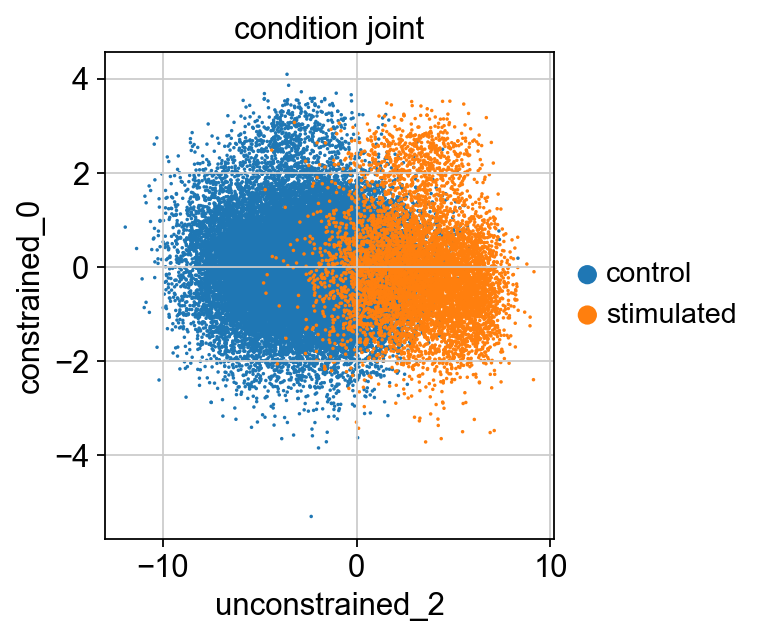

In [45]:
sc.pl.scatter(kang_pbmc, x='unconstrained_2', y='constrained_0', color='condition_joint', size=10)

Note that the signal associated with the program learned by `unconstrained_2` was enriched in stimulated condition compared to control. Here, the cells are separated by their latent scores for `unconstrained_2`, which suggests that this node is indeed capturing the variation induced by IFN-beta stimulation.

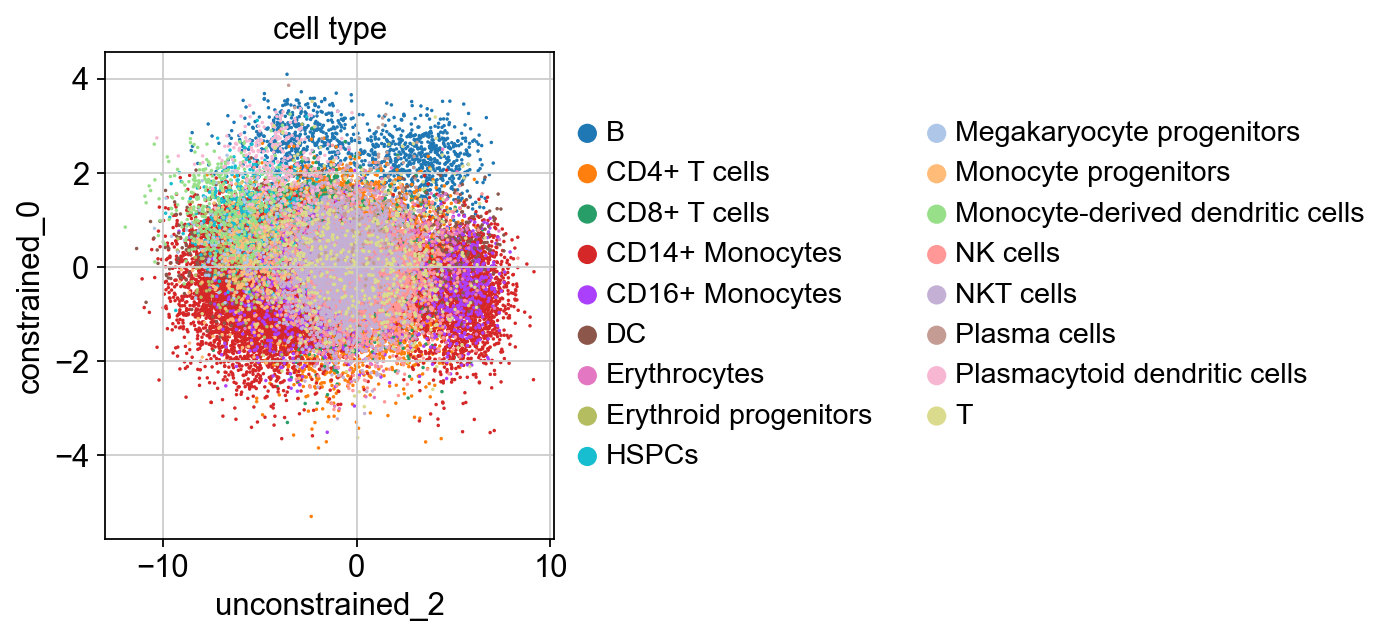

In [46]:
sc.pl.scatter(kang_pbmc, x='unconstrained_2', y='constrained_0', color='cell_type', size=10)

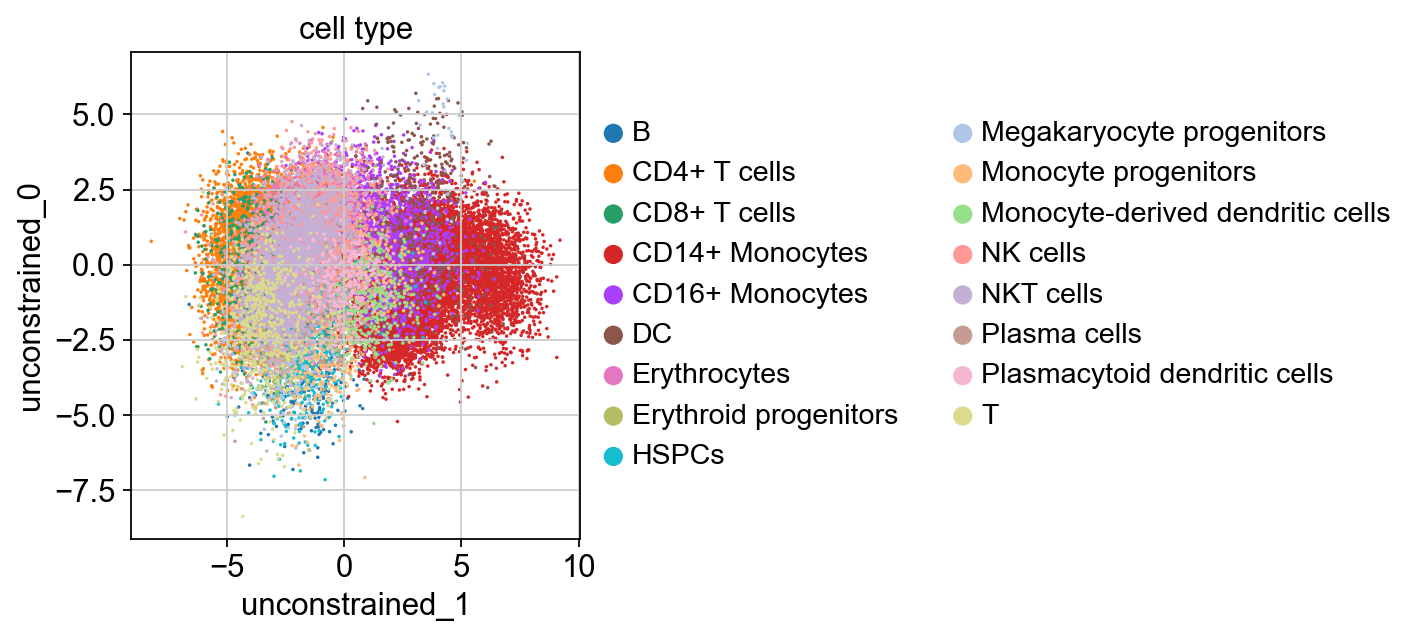

In [47]:
sc.pl.scatter(kang_pbmc, x='unconstrained_1', y='unconstrained_0', color='cell_type', size=10)

Recall that `unconstrained_1` was differentially enriched in CD14+ Monocytes. Therefore, this node is capturing the CD14+ Monocyte cell type variation.

Get genes from extension nodes sorted by their absolute weights in the decoder. Higher absolute value of the weight means that this gene is affected more by the gene program.

In [48]:
q_intr_cvae.term_genes('constrained_0', terms=kang_pbmc.uns['terms'])

genes   weights  in_mask
0      CD79A -1.686799     True
1        BLK -1.411135     True
2       CD19 -1.384097     True
3       BLNK -1.166159     True
4      CD79B -1.164143     True
..       ...       ...      ...
66     STIM1 -0.000940     True
67     CERS4 -0.000227    False
68  HLA-DPB1 -0.000045    False
69     HLA-A  0.000036    False
70     KCNG1 -0.000012    False

[71 rows x 3 columns]

In [51]:
q_intr_cvae.term_genes('unconstrained_1', terms=kang_pbmc.uns['terms'])

genes       weights  in_mask
0        RGS2  3.689368e-01    False
1        CCL2 -3.177418e-01    False
2       TIMP1 -3.089722e-01    False
3      PLA2G7 -2.966527e-01    False
4        GMPR -2.102084e-01    False
..        ...           ...      ...
486    PNPLA8  1.008977e-05    False
487    HS2ST1  8.462230e-06    False
488  SLC25A13 -7.957511e-06    False
489    SLC4A2 -3.113702e-06    False
490      EBF1  3.527966e-07    False

[491 rows x 3 columns]

In [50]:
q_intr_cvae.term_genes('unconstrained_2', terms=kang_pbmc.uns['terms'])

genes   weights  in_mask
0      IFIT3 -0.341521    False
1      IFIT1 -0.338443    False
2      IFIT2 -0.335060    False
3     CXCL10 -0.334820    False
4      ISG15 -0.332265    False
..       ...       ...      ...
391   ZNF235 -0.000018    False
392      ILK -0.000017    False
393     RGS2  0.000017    False
394  SLC44A1  0.000006    False
395    FURIN  0.000003    False

[396 rows x 3 columns]

Note that `unconstrained_2` was capturing the variation induced by IFN-beta stimulation. Here, the genes from the Interferon Induced Protein gene family have the largest absolute weights in the program captured by this unconstrained node, certifying that the learned program is indeed capturing variations in gene expression due to activity of the inteferon signalling, which was induced by IFN-beta stimulation.